In [142]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


### Dataset
In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able link:
```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [144]:
df = pd.read_csv(f"https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")

#### Preparation
* Create the target variable by mapping yes to 1 and no to 0.
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [145]:
df['target'] =df.card.map({'yes':1,'no':0})

In [146]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [147]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

df_train.drop(columns=['card','target'],inplace=True)
df_val.drop(columns=['card','target'],inplace=True)
df_test.drop(columns=['card','target'],inplace=True)

#### Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the card variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* reports
* dependents
* active
* share

In [148]:
dic = {}
columns_auc = ['reports','dependents','active','share']
for c in columns_auc:
    dic[c] = roc_auc_score(y_train , df_train[c])
dic

{'reports': 0.28333701393106236,
 'dependents': 0.46722427722262094,
 'active': 0.6043173411362006,
 'share': 0.989183643423692}

#### Training the model
From now on, use these columns only:
```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [149]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", \
           "months", "majorcards", "active", "owner", "selfemp"]

In [150]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.615
* 0.515
* 0.715
* 0.995

In [151]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
round(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),3)

0.995

#### Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [152]:
precision = []
recall = []
f1 = []
y_pred = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0,1,0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision.append( tp / (tp + fp))
    recall.append( tp / (tp + fn))

In [153]:
f1 = 2*np.array(precision)*np.array(recall)/(np.array(precision)+np.array(recall))
f1 = list(f1)

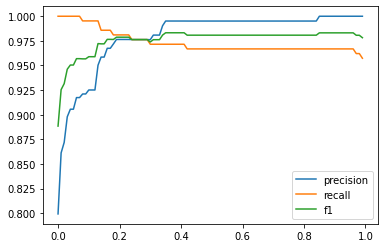

In [154]:
plt.plot(thresholds,precision,label='precision')
plt.plot(thresholds,recall,label = 'recall')
plt.plot(thresholds,f1,label='f1')
plt.legend()

In [192]:
precision[10] - recall[10]

-0.07015053134851867

0.9761904761904762

#### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.1
* 0.4
* 0.6
* 0.7

In [193]:
best_threshold = round(thresholds[f1.index(max(f1))],1)
best_threshold

0.4

#### Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

* 0.003
* 0.014
* 0.09
* 0.24

In [162]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [176]:
scores=[] 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['target'].values
    y_val = df_val['target'].values
    
    df_train =df_train.drop(columns=['target','card'])
    df_val =df_val.drop(columns=['target','card'])

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [179]:
round(np.std(scores),3)

0.003

#### Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]

* Initialize KFold with the same parameters as previously

* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?


* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [180]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['target'].values
        y_val = df_val['target'].values
        
        df_train =df_train.drop(columns=['target','card'])
        df_val =df_val.drop(columns=['target','card'])

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.995 +- 0.004
C=0.1 0.997 +- 0.003
C=1 0.996 +- 0.003
C=10 0.997 +- 0.003
